# Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# PyTorch

import torch as T
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms

Configure GPU

In [2]:
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

# Loading dataset

In [3]:
# Read csv file
train_data = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
# Train data shape
print(f"Train dataset shape: {train_data.shape}")
# Sample of the train_data DataFrame
train_data.head()

Train dataset shape: (10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Distribution of the breed classes

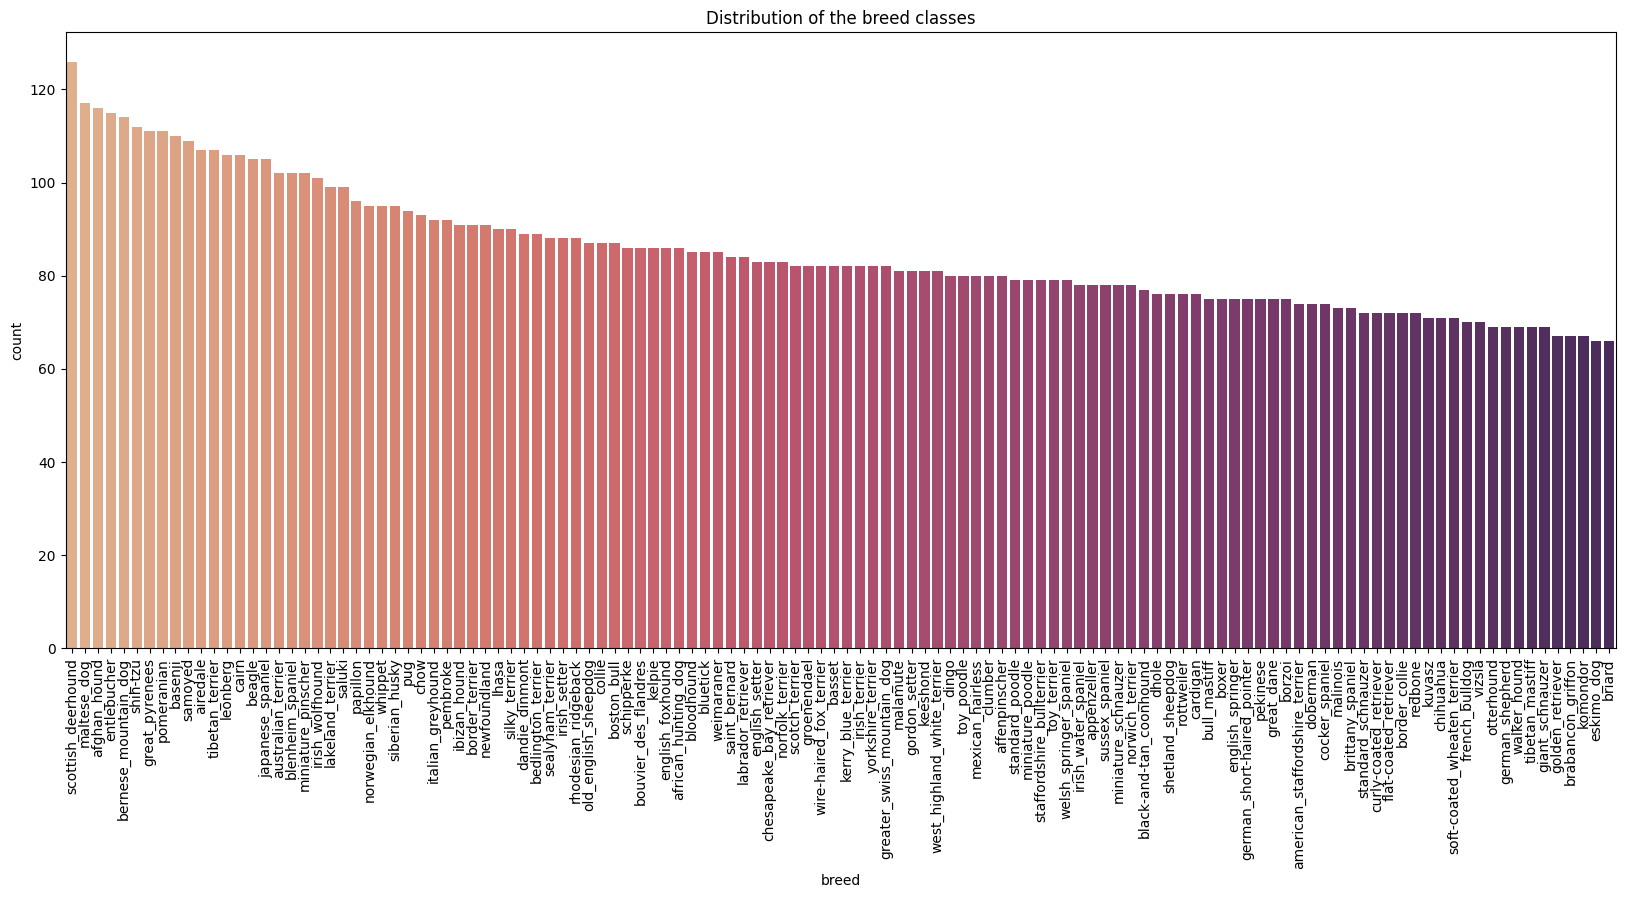

In [4]:
breed_classes = train_data.breed.value_counts().reset_index()
plt.figure(figsize=(20,8))
sns.barplot(breed_classes, x='breed', y='count', palette="flare")
plt.xticks(rotation=90)
plt.title("Distribution of the breed classes")
plt.show()

In [5]:
breed_classes['count'].describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: count, dtype: float64

Confirm the 120 dog breed classes

In [6]:
breed_classes['breed'].nunique()

120

# Label Encoding

In [7]:
le = LabelEncoder()
train_data.loc[:,'breed'] = le.fit_transform(train_data.loc[:,'breed']) 

In [8]:
train_data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


# Dog Breed Dataset

In [5]:
class Dog_Breed_Dataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, img_base_path: str, split: str, transforms = None):        
        self.df = df
        self.img_base_path = img_base_path
        self.split = split
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Path of the image
        img_path = os.path.join(self.img_base_path + self.df.loc[index,'id'] + '.jpg')
        # Read the image
        img = Image.open(img_path)        
        # Perform the transformations
        if self.transforms:
            img = self.transforms(img)
        
        if self.split != 'test':
            y = self.df.loc[index, 'breed']                     
            return img, y
        else:            
            return img
    
    def __len__(self):
        return len(self.df)        

# Data Augmentation

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Get Data Loaders

### Split the dataset

In [7]:
train, val = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['breed'])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

### Get the data loaders

In [8]:
train_dataset = Dog_Breed_Dataset(
    df=train,
    img_base_path='/kaggle/input/dog-breed-identification/train/',
    split='train',
    transforms=train_transforms
)
validation_dataset = Dog_Breed_Dataset(
    df=val,
    img_base_path='/kaggle/input/dog-breed-identification/train/',
    split='val',
    transforms=test_transforms
)

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
validation_dl = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)    

In [9]:
print(f"Train data length: {len(train_dl.dataset)}, Validation data length: {len(validation_dl.dataset)}")

Train data length: 8177, Validation data length: 2045


# Samples of the train data

In [ ]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)   

In [ ]:
img, label = next(iter(train_dl))
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(4):
    ax = grid[i]
    imshow(ax, img[i])    

# Training process

## Training function

In [10]:
def train_model(train_dl, val_dl, model, epochs=30):
    
    # history record
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    # Best validation accuracy
    best_val_acc = 0.0    
    # Get initial weights
    weights = model.get_weights()
    
    for epoch in range(epochs):
        print("="*20, "Epoch: ", str(epoch), "="*20)
        
        train_correct_pred = 0
        val_correct_pred = 0
        train_acc = 0
        val_acc = 0
        train_loss = 0
        val_loss = 0
        
        # Set to training mode
        model.train()
        
        for x, y in train_dl:               
            # Convert data to Tensor            
            x = x.clone().detach().to(device).requires_grad_(True)
            y = y.clone().detach().long().to(device)
            # Reset gradients
            model.optim.zero_grad()
            # Predict
            preds = model(x)                                         
            # Compute the loss            
            loss = model.criterion(preds,y)           
            # Compute the gradients            
            loss.backward()
            # Update weights
            model.optim.step()
            # Count the correct predictions
            preds = T.argmax(preds, dim=1)           
            train_correct_pred += (preds.long().unsqueeze(1) == y.unsqueeze(1)).sum().item()            
            train_loss += loss.item()           
        
        model.scheduler.step()
        # Compute the training acuracy
        train_acc = train_correct_pred / len(train_dl.dataset)
        
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        
        # Switch to evaluation mode
        model.eval()        
        
        with T.no_grad():
            for x, y in val_dl:                
                # Convert data to Tensor                
                x = x.clone().detach().to(device)
                y = y.clone().detach().long().to(device)    
                # Predict
                preds = model(x)                
                # Compute the loss
                loss = model.criterion(preds, y)
                
                val_loss += loss.item()
                # Count the correct predictions
                preds = T.argmax(preds, dim=1)                
                val_correct_pred += (preds.long().unsqueeze(1) == y.unsqueeze(1)).sum().item()            
        # Compute the validation accuracy
        val_acc = val_correct_pred / len(val_dl.dataset)
        
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)           
        
        if best_val_acc > val_acc:
            best_val_acc = val_acc
            weights = model.get_weights()
            
        print("Train acc: {:.4f} | Train Loss: {:.4f} | Validation acc: {:.4f} | Validation Loss: {:.4f}".format(train_acc, train_loss, val_acc, val_loss))
    model.load_weights(weights)
    return [train_acc_history, train_loss_history, val_acc_history, val_loss_history], model

## Models

Inception model

In [11]:
inception = models.inception_v3(pretrained=True)

inception_model = nn.Sequential(
    inception.Conv2d_1a_3x3,
    inception.Conv2d_2a_3x3,
    inception.Conv2d_2b_3x3,
    inception.maxpool1,
    inception.Conv2d_3b_1x1,
    inception.Conv2d_4a_3x3,
    inception.maxpool2,
    inception.Mixed_5b,
    inception.Mixed_5c,
    inception.Mixed_5d,
    inception.Mixed_6a,
    inception.Mixed_6b,
    inception.Mixed_6c,
    inception.Mixed_6d,
    inception.Mixed_6e,
    inception.Mixed_7a,
    inception.Mixed_7b,
    inception.Mixed_7c,
    inception.avgpool
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 132MB/s]  


Resnet50 model

In [12]:
resnet50 = models.resnet50(pretrained=True)

resnet50_model = nn.Sequential(
    resnet50.conv1,
    resnet50.bn1,
    resnet50.relu,
    resnet50.maxpool,
    resnet50.layer1,
    resnet50.layer2,
    resnet50.layer3,
    resnet50.layer4,
    resnet50.avgpool
)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s] 


In [13]:
# Freeze parameters of pretrained models
for param in resnet50_model.parameters():    
    param.requires_grad = False
    
for param in inception_model.parameters():    
    param.requires_grad = False

### Model class

In [14]:
class Model(nn.Module):
    
    def __init__(self, inception_model, resnet50_model):
        super(Model,self).__init__()
        
        self.inception_model = inception_model
        self.resnet50_model = resnet50_model        
        
        self.output = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(4096,120)            
        )
        
        self.to(device)
        # Optimizer 
        self.optim = T.optim.SGD(self.output.parameters(), lr=0.001, momentum=0.9)
        # Loss
        self.criterion = T.nn.CrossEntropyLoss()
        # Scheduler
        self.scheduler = T.optim.lr_scheduler.StepLR(self.optim, step_size=7, gamma=0.1)
        
    def forward(self, x):
        X1 = self.inception_model(x)
        X2 = self.resnet50_model(x)
        
        X1 = X1.view(X1.size(0), -1)
        X2 = X2.view(X2.size(0), -1)
       
        X = T.cat([X1, X2], dim=1)
                
        return self.output(X)
    
    def get_weights(self):
        return self.output.state_dict()
    
    def load_weights(self, weights):
        self.output.load_state_dict(weights)

## Training model

In [15]:
model = Model(inception_model, resnet50_model)

In [16]:
history, model = train_model(train_dl, validation_dl, model)

==================== Epoch:  0 ====================
Train acc: 0.0995 | Train Loss: 568.3780 | Validation acc: 0.4856 | Validation Loss: 114.3710
==================== Epoch:  1 ====================
Train acc: 0.3619 | Train Loss: 437.3580 | Validation acc: 0.6660 | Validation Loss: 83.4642
==================== Epoch:  2 ====================
Train acc: 0.5030 | Train Loss: 348.6673 | Validation acc: 0.7213 | Validation Loss: 63.9928
==================== Epoch:  3 ====================
Train acc: 0.5766 | Train Loss: 291.8582 | Validation acc: 0.7579 | Validation Loss: 51.9739
==================== Epoch:  4 ====================
Train acc: 0.6084 | Train Loss: 256.5247 | Validation acc: 0.7795 | Validation Loss: 44.1387
==================== Epoch:  5 ====================
Train acc: 0.6486 | Train Loss: 227.1407 | Validation acc: 0.7907 | Validation Loss: 39.4070
==================== Epoch:  6 ====================
Train acc: 0.6587 | Train Loss: 213.2628 | Validation acc: 0.7966 | Validatio

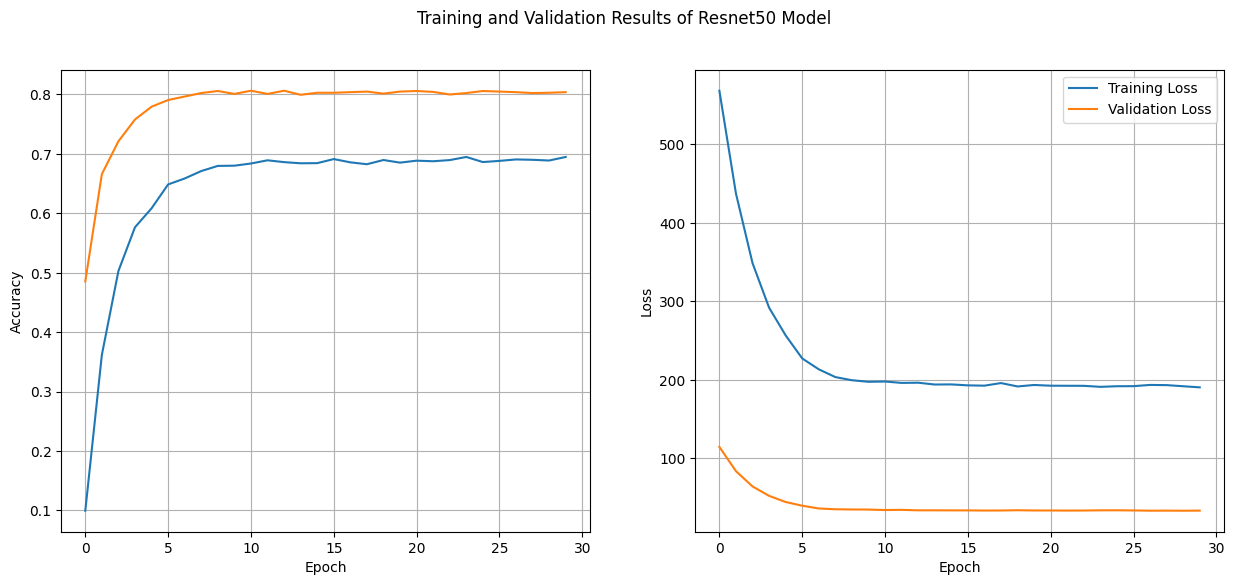

In [17]:
# Training and Validation Results
fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].plot(range(30), history[0], label="Training accuracy")
axs[0].plot(range(30), history[2], label="Validation accuracy")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

axs[1].plot(range(30), history[1], label="Training Loss")
axs[1].plot(range(30), history[3], label="Validation Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.suptitle("Training and Validation Results of Resnet50 Model")
plt.legend()
plt.show()

# Submission

## Read test data

In [18]:
test_data = pd.DataFrame([])
for dirname, _, filename in os.walk('/kaggle/input/dog-breed-identification/test/'):
    filename = pd.Series(filename)
    test_data = pd.concat([test_data, filename], axis=0)
test_data.columns = ['id']
test_data['id'] = test_data['id'].str.replace(".jpg","")

In [19]:
# Dataset shape
print(f"Test dataset shape: {test_data.shape}")
# Sample of the train_data DataFrame
test_data.head()

Test dataset shape: (10357, 1)


,id
0,09e51e17e2b756ff2ace8a87bd1443fa
1,f7a32505c12649183c5991ecfa7d68b3
2,bc6d50ffb4644feb34530aa58943e85b
3,7cbc041e79135a572aad87904b5c9c57
4,f3b603f10d6a344f0395fb46b242ff8e


## Get Test Data Loader

In [20]:
test_dataset = Dog_Breed_Dataset(
    df=test_data,
    img_base_path='/kaggle/input/dog-breed-identification/test/',
    split='test',
    transforms=test_transforms
)

test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [21]:
def test_model(test_dl, model):       
              
        # Predictions DataFrame
        prob_preds = pd.DataFrame([])
        
        for x in test_dl:
            # Convert data to Tensor            
            x = x.clone().detach().to(device)            
            # Predict
            pred = model(x)  
            prob_pred = T.nn.functional.softmax(pred, dim=1)
            
            prob_pred = prob_pred.detach().cpu().numpy()             
            prob_pred = pd.DataFrame(prob_pred)
            
            prob_preds = pd.concat([prob_preds, prob_pred], axis=0)            
            
        return prob_preds            

In [22]:
test_preds = test_model(test_dl, model)
test_preds.shape

(10357, 120)

In [23]:
test_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.000591,0.000168,0.000652,0.000340,0.372313,0.001027,0.001401,0.004137,0.000625,0.001469,...,0.000718,0.001896,0.000386,0.001097,0.000205,0.000217,0.001880,0.001934,0.001059,0.001200
1,0.000099,0.000337,0.000065,0.000552,0.001057,0.000187,0.000492,0.002030,0.006792,0.002184,...,0.000312,0.000209,0.051276,0.002813,0.000443,0.000713,0.000106,0.000519,0.000182,0.000336
2,0.000574,0.020001,0.002104,0.002117,0.001203,0.001239,0.001249,0.000673,0.001257,0.000586,...,0.000990,0.000736,0.000421,0.000767,0.000603,0.001817,0.000990,0.001411,0.000934,0.000532
3,0.000186,0.000332,0.000261,0.000447,0.004327,0.000628,0.000326,0.004530,0.000429,0.000358,...,0.000297,0.006325,0.001065,0.000974,0.019697,0.000255,0.000870,0.145293,0.002228,0.000228
4,0.000110,0.000792,0.000317,0.000394,0.000409,0.001042,0.000593,0.001389,0.015194,0.001781,...,0.000221,0.000356,0.000588,0.005698,0.000135,0.837856,0.000294,0.000610,0.000743,0.000237


In [24]:
# Set columns to breed names
num_classes = []
for num_class in test_preds.columns:
    num_classes.append(num_class)

num_classes = np.array(num_classes)
num_classes = le.inverse_transform(num_classes)
test_preds.columns = list(num_classes)

In [25]:
test_preds.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000591,0.000168,0.000652,0.000340,0.372313,0.001027,0.001401,0.004137,0.000625,0.001469,...,0.000718,0.001896,0.000386,0.001097,0.000205,0.000217,0.001880,0.001934,0.001059,0.001200
1,0.000099,0.000337,0.000065,0.000552,0.001057,0.000187,0.000492,0.002030,0.006792,0.002184,...,0.000312,0.000209,0.051276,0.002813,0.000443,0.000713,0.000106,0.000519,0.000182,0.000336
2,0.000574,0.020001,0.002104,0.002117,0.001203,0.001239,0.001249,0.000673,0.001257,0.000586,...,0.000990,0.000736,0.000421,0.000767,0.000603,0.001817,0.000990,0.001411,0.000934,0.000532
3,0.000186,0.000332,0.000261,0.000447,0.004327,0.000628,0.000326,0.004530,0.000429,0.000358,...,0.000297,0.006325,0.001065,0.000974,0.019697,0.000255,0.000870,0.145293,0.002228,0.000228
4,0.000110,0.000792,0.000317,0.000394,0.000409,0.001042,0.000593,0.001389,0.015194,0.001781,...,0.000221,0.000356,0.000588,0.005698,0.000135,0.837856,0.000294,0.000610,0.000743,0.000237


In [26]:
# Set id column
test_preds = test_preds.reset_index(drop=True)
ids = test_data.loc[:,'id']
test_preds = pd.concat([ids, test_preds], axis=1)
test_preds.head()

In [31]:
test_preds.to_csv('submission.csv', index=None)